In [ ]:
"""
input:
    - combined_socio_economic_parameters.parquet
    - main_configs.json
output:
    - atv_score_and_{clm}.png
    - socio_economic_params_correlation_heatmap.png
    - socio_economic_params_pca.png
    - figure5.pdf
    - pca_explained_variance_ratio.pdf
"""

In [2]:
import os
import copy
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

from src.scripts.common_figures import Figures

In [3]:
supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

figures = Figures()

In [4]:
combined_df = pd.read_parquet(f"{dataframes_path}/combined_socio_economic_parameters.parquet")
columns = combined_df.columns[1:-2]

with open("/src/main_configs.json", 'r') as f:
    main_configs = json.load(f)

labels = copy.deepcopy(main_configs['socio_economic_parameter_names'])
labels_abbr = copy.deepcopy(main_configs['socio_economic_params_abbr'])

In [5]:
main_configs["socio_economic_parameter_names"]

['Non-native Percentage',
 'Education (Percent Less Than High School)',
 'Education (Percent Greater Than Bachelor)',
 'Unemployment Percentage',
 'Median Household Income',
 'Poverty',
 'Black Percentage',
 '2020 Presidential Election Index (Trump% - Biden%)',
 'Per Capita Income',
 '$log(Cat/Dog)$']

In [6]:
combined_df.head()

,state,nonnative_perc,plths_perc,pgtbch_perc,unemployment_perc,median_household,poverty_perc,black_perc,president,social_capita,cat_dog_ratio,tweet_counts,odd_ratios
0,AK,0.033097,0.355479,0.318555,0.081370,80197,0.091525,0.029367,0.100612,0.39,-0.362661,657,0.471756
1,AL,0.020432,0.411211,0.278057,0.059426,53956,0.146839,0.251810,0.254617,-0.94,-0.586082,3779,-0.100419
2,AR,0.031001,0.462472,0.248960,0.064616,51183,0.153317,0.145029,0.276207,-1.29,-0.393904,2246,-0.208552
3,AZ,0.062468,0.343174,0.329732,0.065186,64777,0.127909,0.046272,-0.003087,-1.33,-0.487836,8280,-0.253782
4,CA,0.117392,0.352820,0.369291,0.082017,83056,0.114284,0.055902,-0.291632,-0.85,-0.147567,44623,0.171503


In [7]:
print("Num. of Pro States:", combined_df[combined_df['odd_ratios'] > 0].shape[0])
print("Num. of Anti States:", combined_df[combined_df['odd_ratios'] < 0].shape[0])

Num. of Pro States: 25
Num. of Anti States: 25


In [8]:
colorbars = [False if idx % 2 == 0 else True for idx in range(len(columns))]

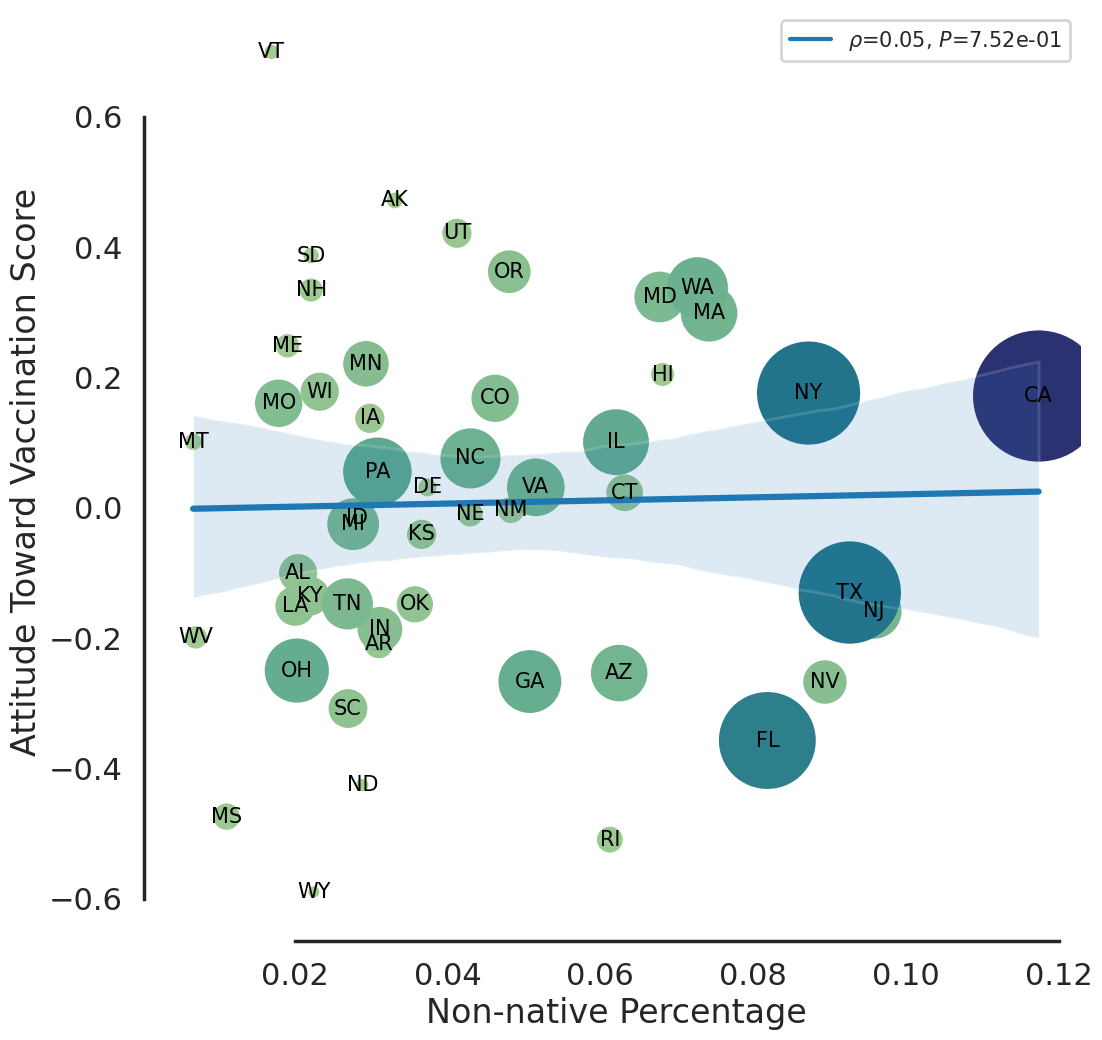

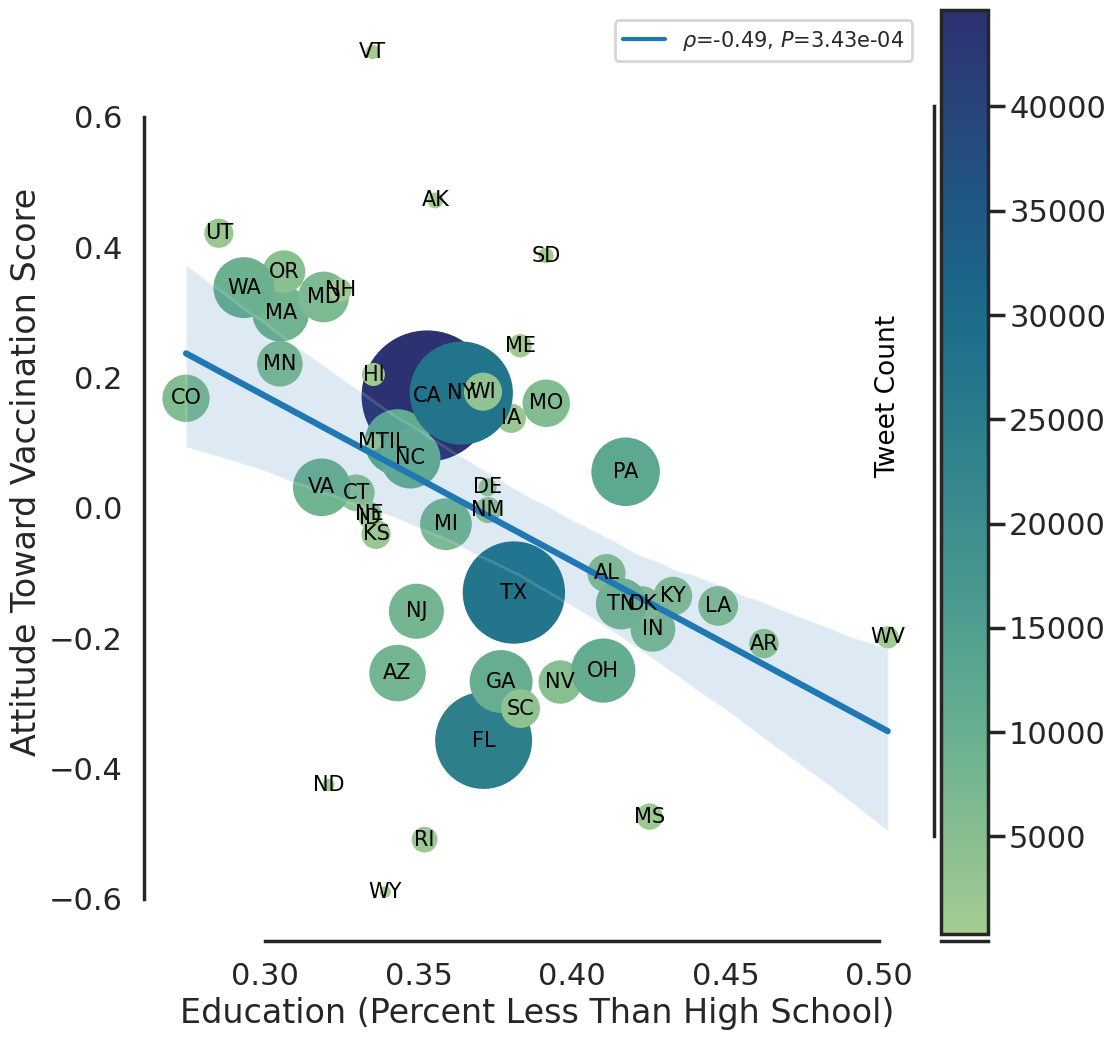

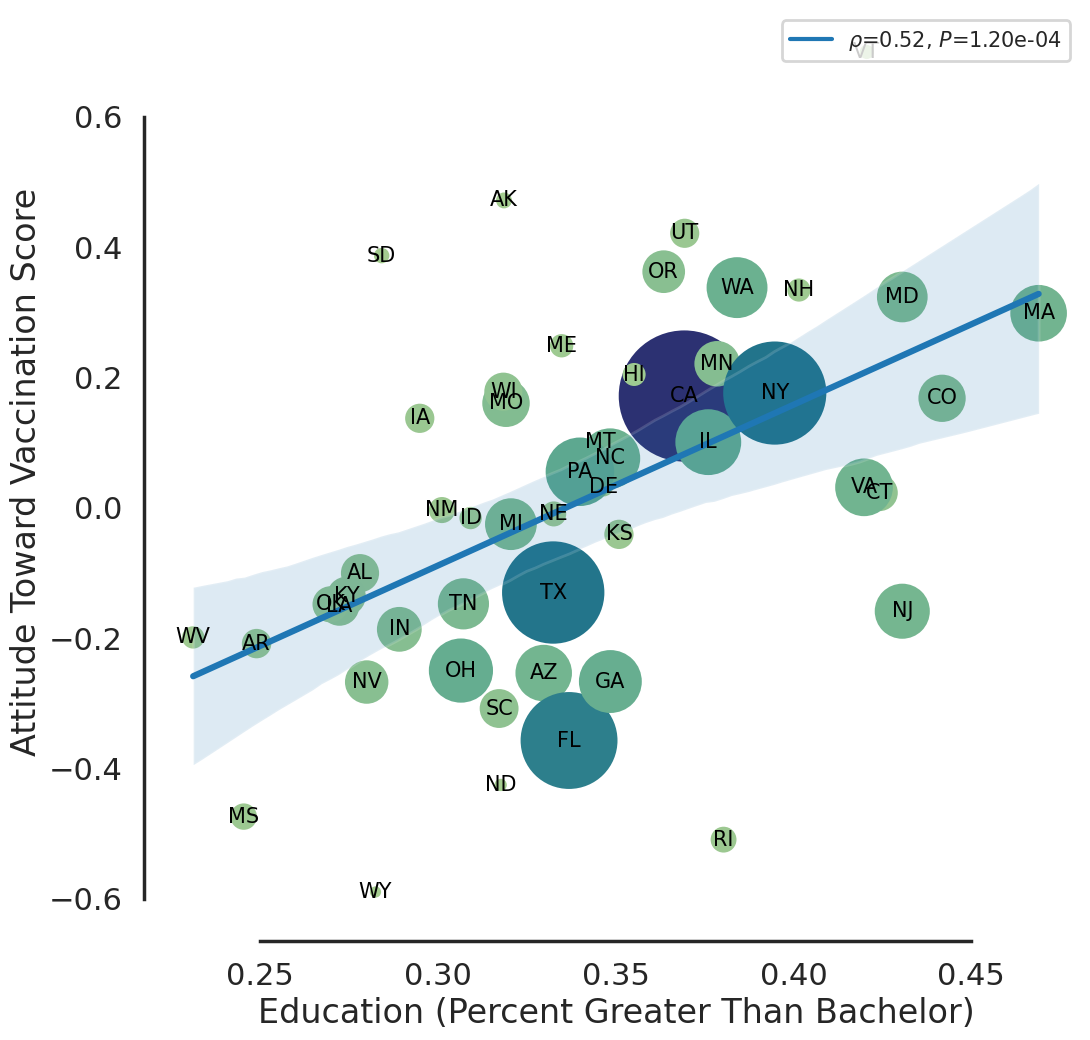

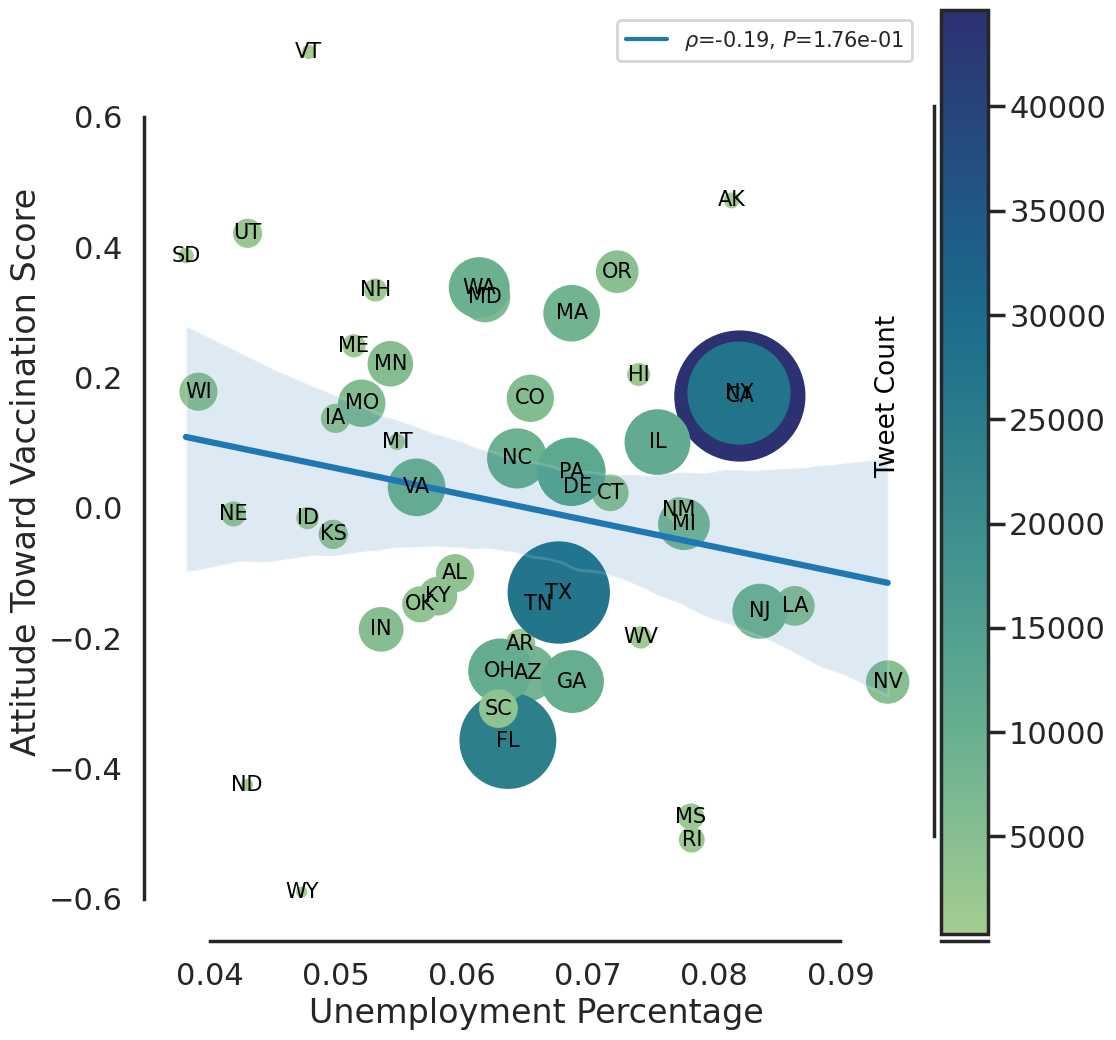

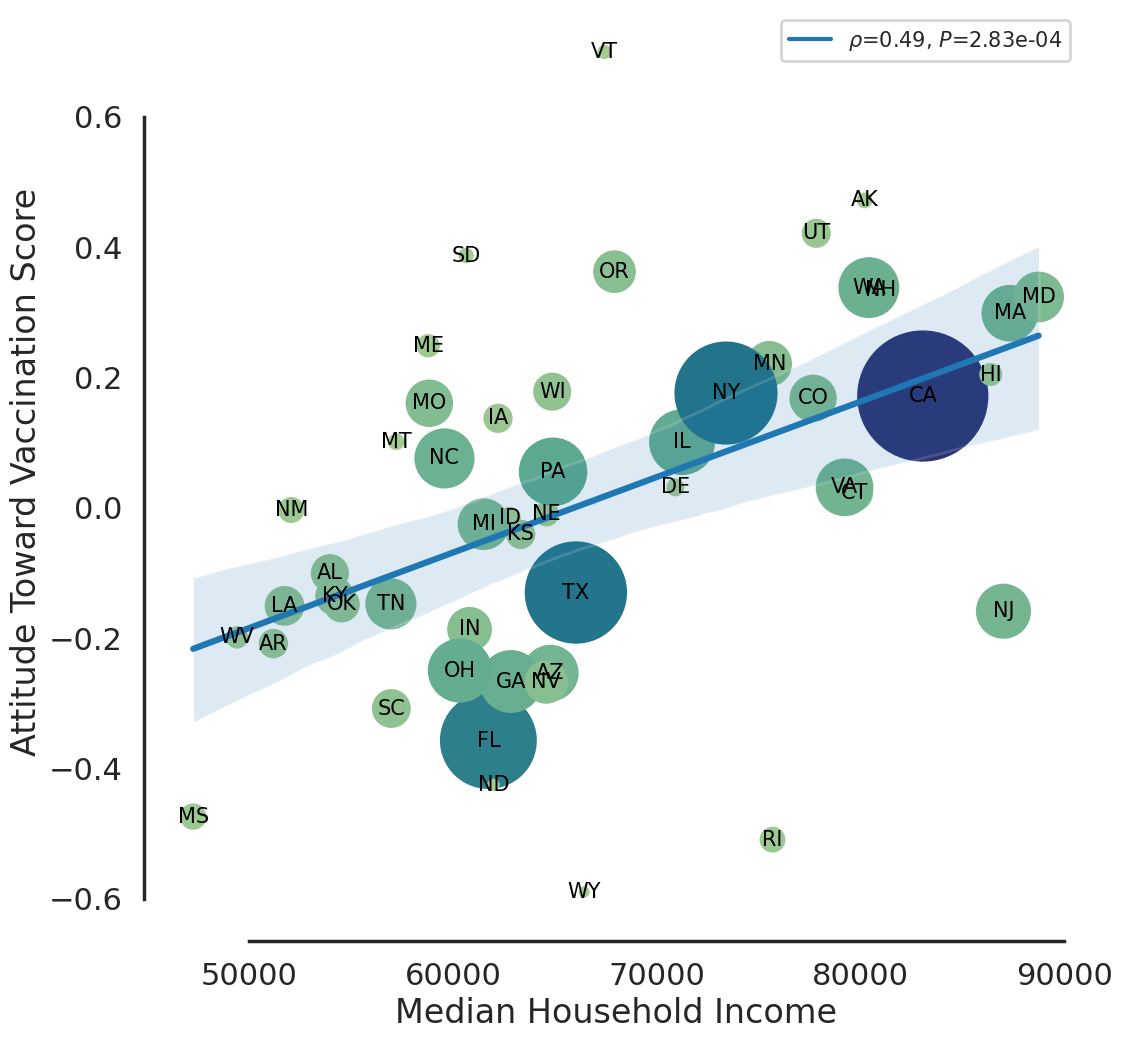

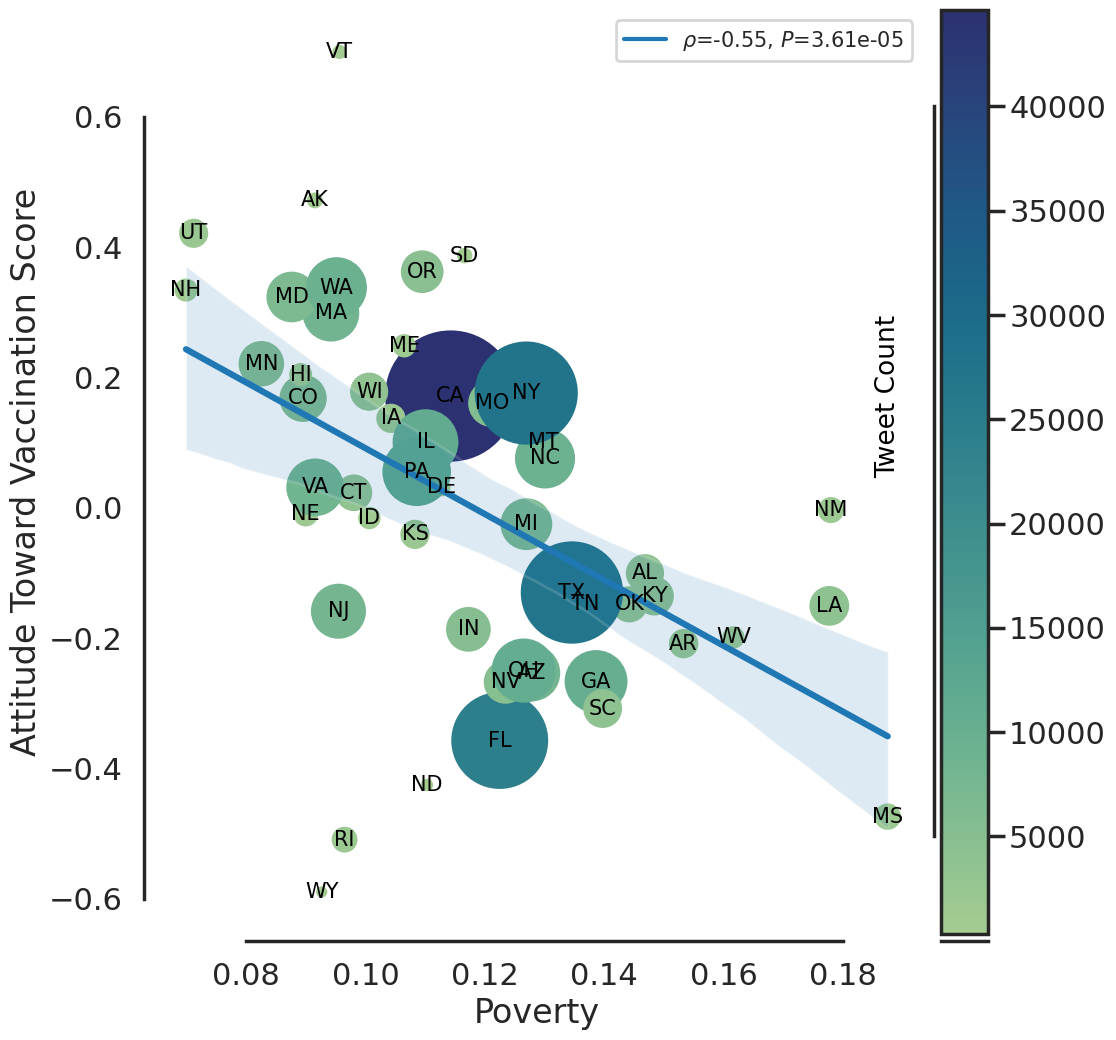

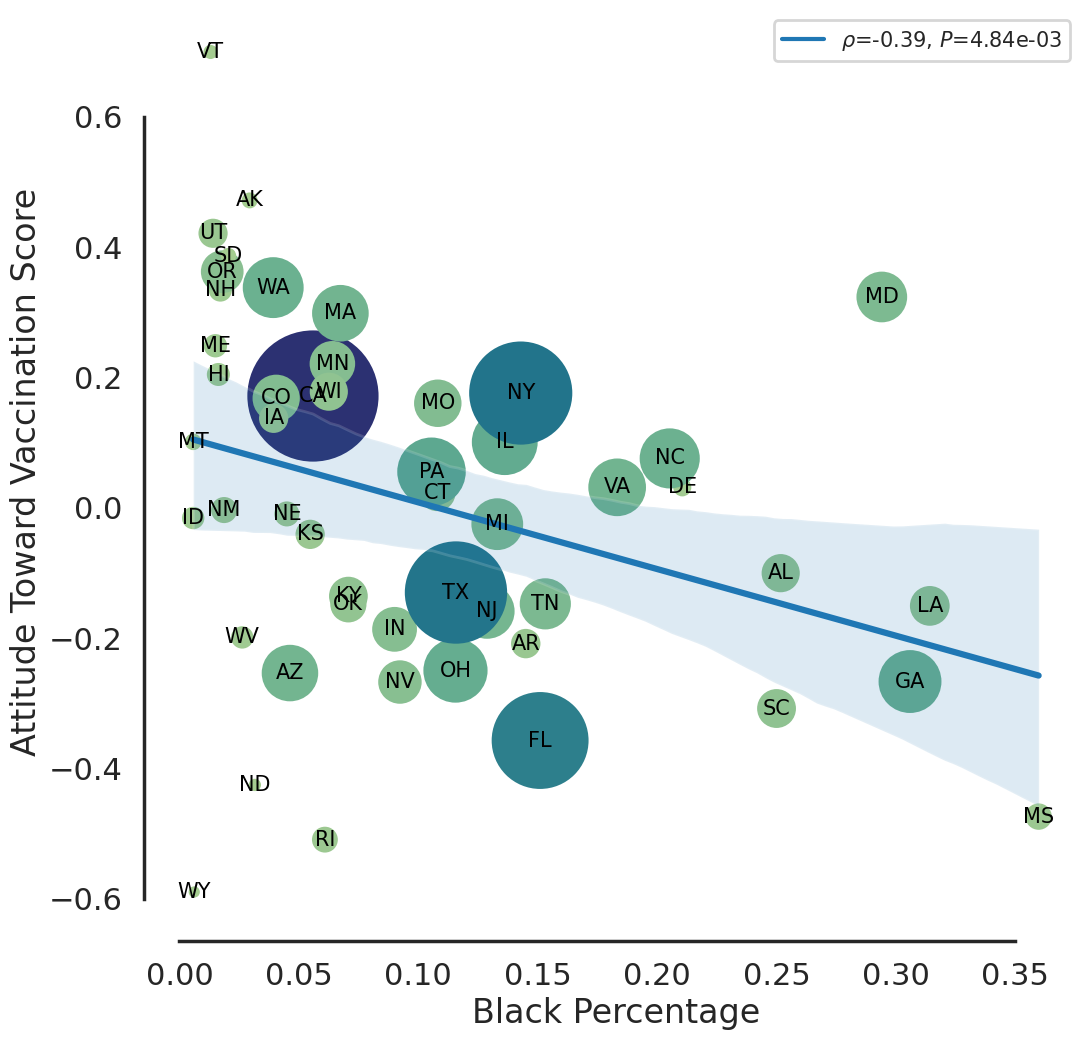

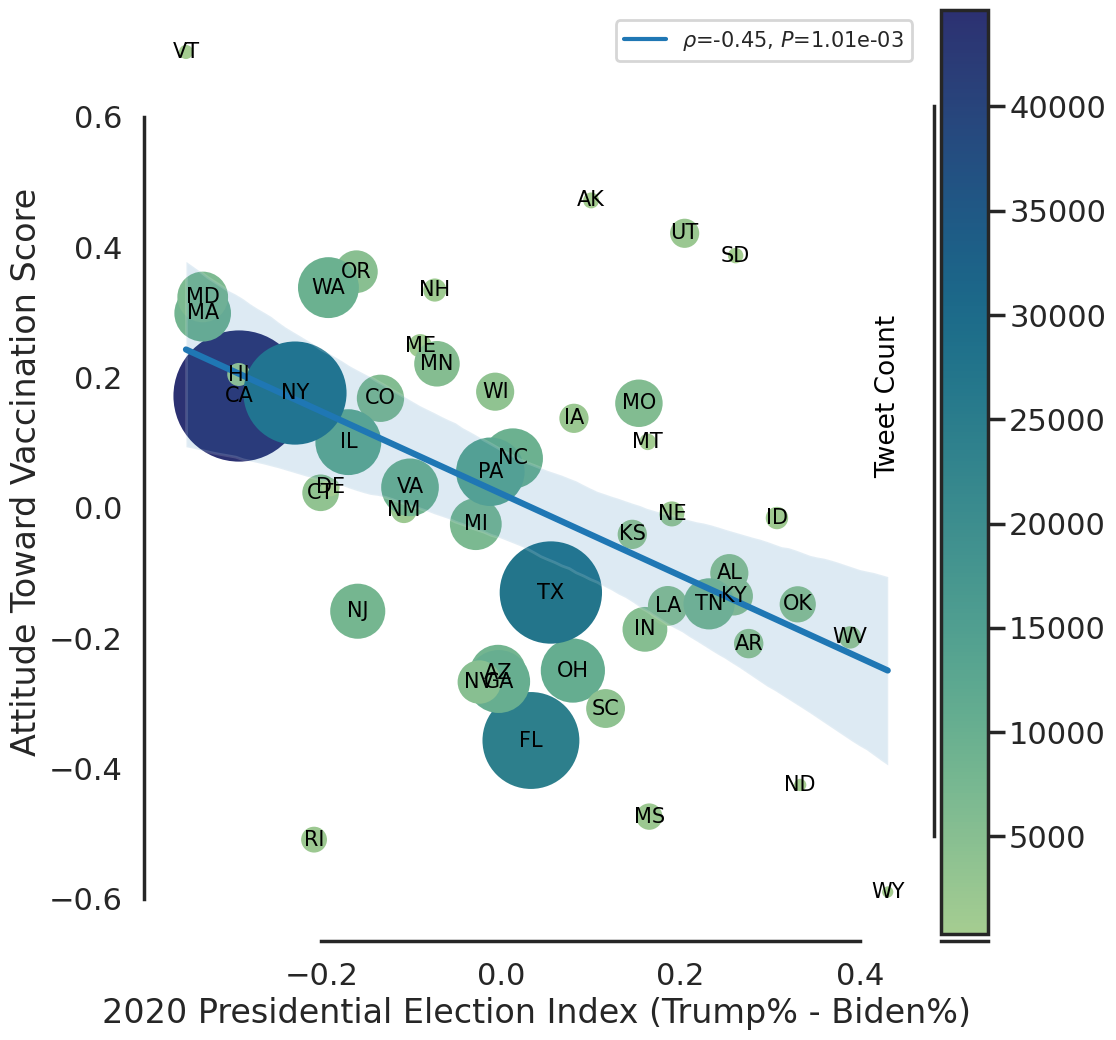

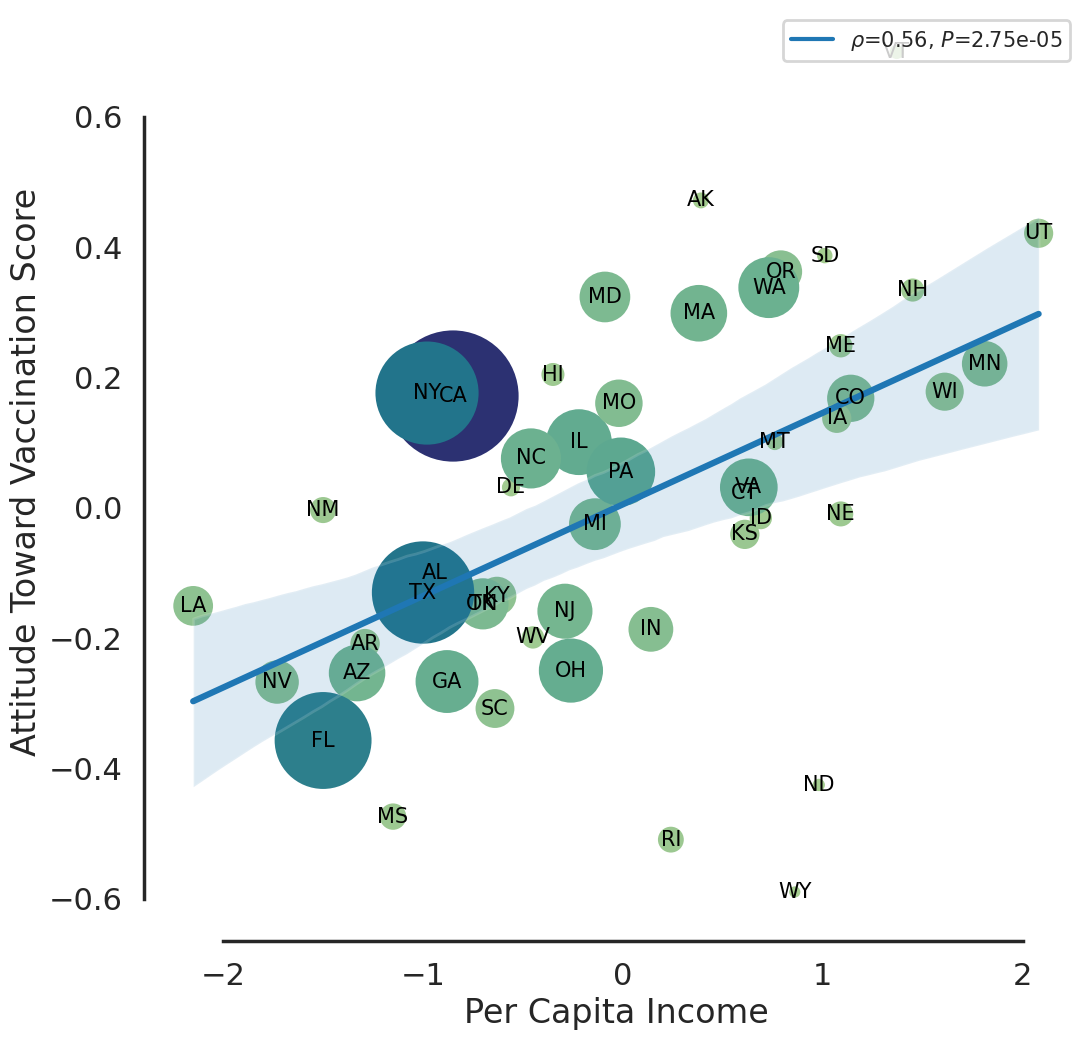

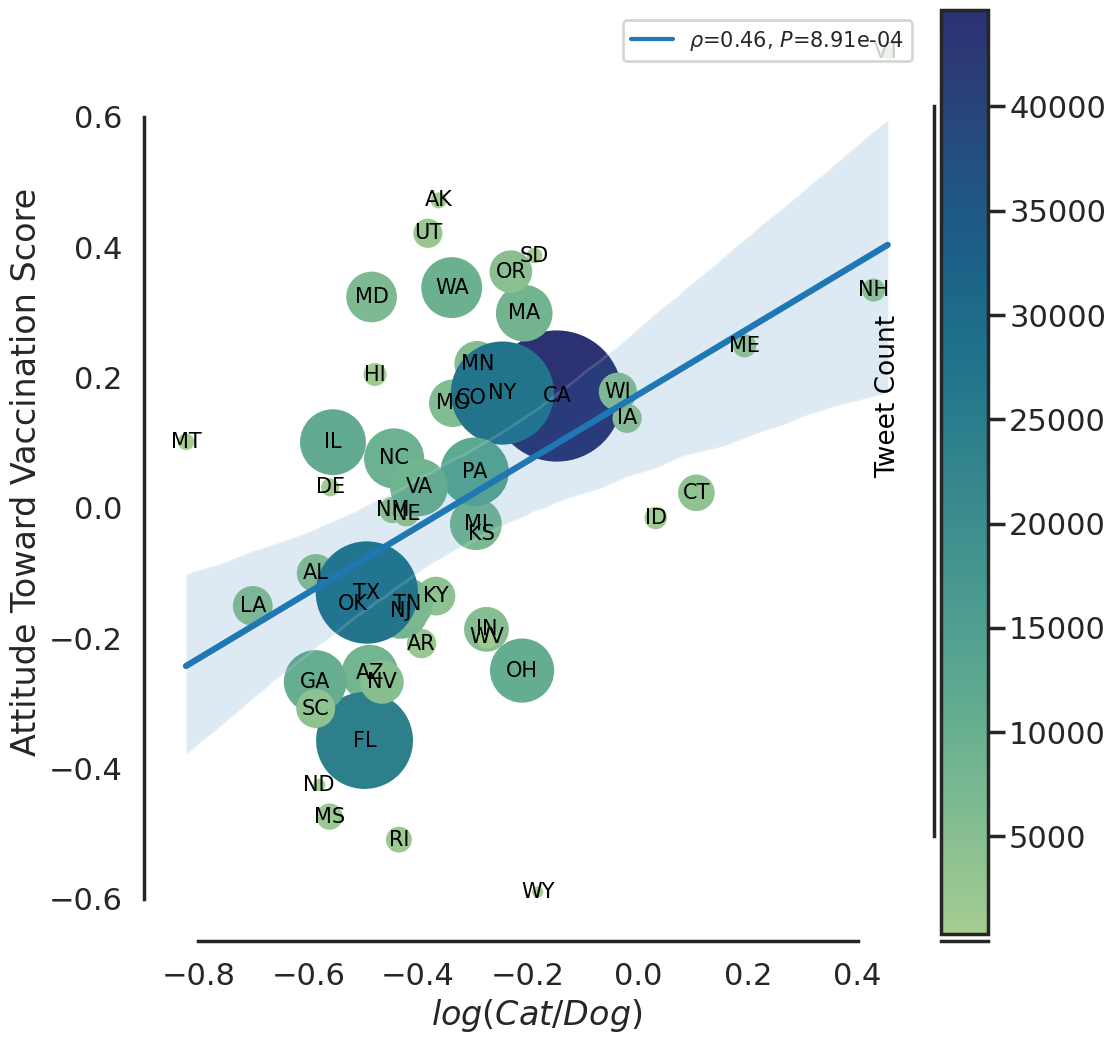

In [ ]:
os.makedirs(f"{supp_figures_path}/atv_score_and_socio_economic_parameter_correlations", exist_ok=True)
for idx, clm in enumerate(columns):
    save = f"{supp_figures_path}/atv_score_and_socio_economic_parameter_correlations/atv_score_and_{clm}.svg"
    figures.draw_correlation_figure(combined_df, clm, 'odd_ratios',
                                    labels[idx], 'Attitude Toward Vaccination Score', figsize=(12, 12),
                                    point_size_multiplexer=0.2, colorbar=colorbars[idx], save=None, paper_figure=save)

## Heatmap and PCA

In [12]:
only_socio_economic_params = combined_df.drop(columns=['state', 'tweet_counts', 'odd_ratios'])
only_socio_economic_params.columns = labels_abbr

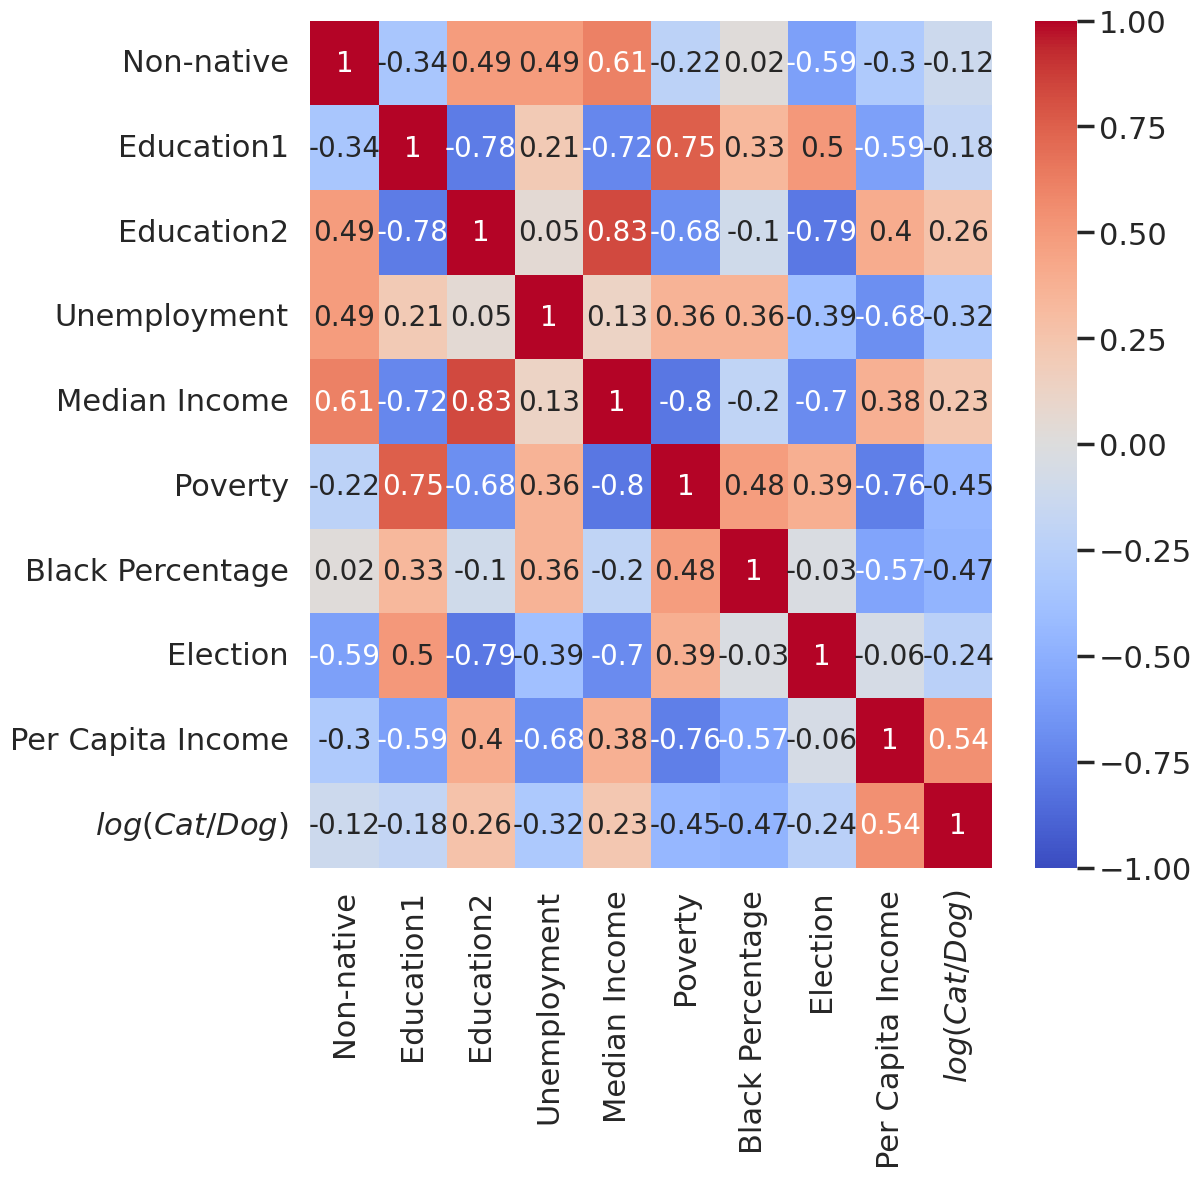

In [ ]:
sns.set_context("poster", font_scale=0.9)
sns.set_style("white")
plt.figure(figsize=(12, 9))

sns.heatmap(np.round(only_socio_economic_params.corr(), 2),
            cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 20})

plt.savefig(f"{main_figures_path}/socio_economic_params_correlation_heatmap.png", dpi=300, bbox_inches='tight')

### PCA

In [13]:
sc = StandardScaler()
state_lev_data_std = sc.fit_transform(only_socio_economic_params)
n_components = state_lev_data_std.shape[1]

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(state_lev_data_std)

In [14]:
pca_df = pd.concat([pd.DataFrame(X_pca[:, :2], columns=['x1', 'x2']),
                    combined_df[['state', 'tweet_counts', 'odd_ratios']]], axis=1).reset_index(drop=True)

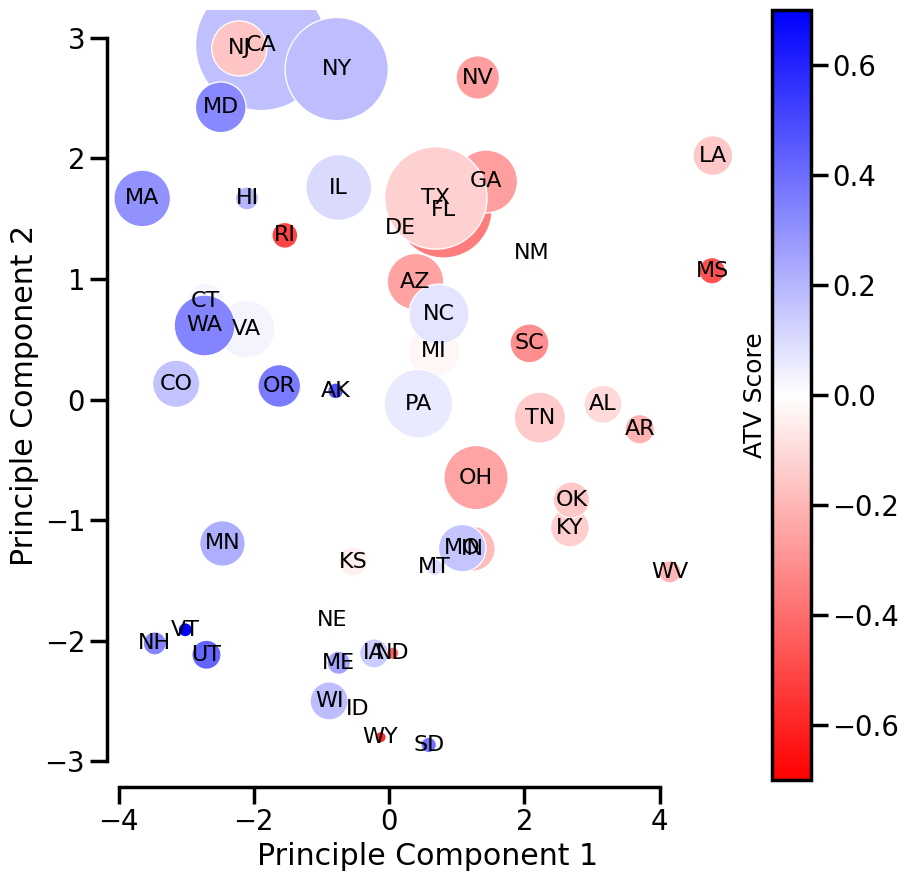

In [ ]:
save = f"{main_figures_path}/socio_economic_params_pca.png"
colors = ['red','white', 'blue']

sns.reset_orig()
sns.set_context("poster", font_scale=0.9)
figures.scatter_pca(pca_df, 'x1', 'x2', colors, figsize=(12, 9),
                     point_size_multiplexer=0.2, save=save, paper_figure=None)

## Biplot

In [15]:
sc = StandardScaler()
state_lev_data_std = sc.fit_transform(only_socio_economic_params)
n_components = state_lev_data_std.shape[1]

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(state_lev_data_std)

In [16]:
pca_df = pd.concat([pd.DataFrame(X_pca[:, :2], columns=['x1', 'x2']),
                    combined_df[['state', 'tweet_counts', 'odd_ratios']]], axis=1).reset_index(drop=True)

In [17]:
i = np.identity(state_lev_data_std.shape[1])
coef = pca.transform(i)

coef_df = pd.DataFrame({'params': labels_abbr,
                        'pc1': coef[:, 0].reshape(-1,),
                        'pc2': coef[:, 1].reshape(-1,)})

In [18]:
coef_df

,params,pc1,pc2
0,Non-native,-0.190644,0.445308
1,Education1,0.401486,-0.007066
2,Education2,-0.405721,0.185800
3,Unemployment,0.085779,0.507289
4,Median Income,-0.410906,0.197403
5,Poverty,0.422411,0.133923
6,Black Percentage,0.206902,0.313862
7,Election,0.307520,-0.344634
8,Per Capita Income,-0.310990,-0.407328
9,$log(Cat/Dog)$,-0.221650,-0.263981


In [20]:
def mid_point(values):
    return (np.max(values) + np.min(values)) / 2

<ipython-input-21-3c636ed0be57>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.figure.colorbar(sm, pad=0.04)


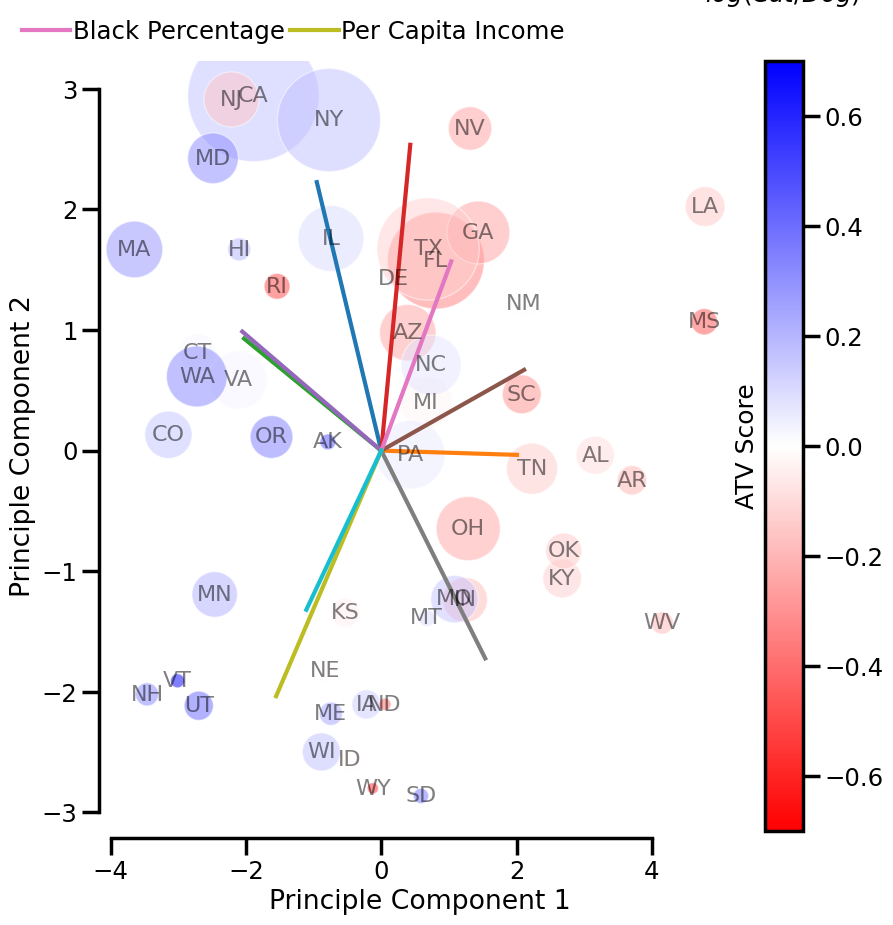

In [21]:
save = f"{supp_figures_path}/figure5.pdf"
colors = ['red','white', 'blue']

sns.reset_orig()
sns.set_context("poster", font_scale=0.8)

df = pca_df
x, y = 'x1', 'x2'
figsize = (10, 10)
point_size_multiplexer = 0.2

colormap = LinearSegmentedColormap.from_list(
            name='test', 
            colors=colors
        )

plt.figure(figsize=figsize)

min_max = np.max(np.abs([df['odd_ratios'].values.min(), df['odd_ratios'].values.max()]))
fig = sns.scatterplot(data=df, x=x, y=y, c=df['odd_ratios'].values, s=df['tweet_counts'].values*point_size_multiplexer,
                        cmap=colormap, vmin=-min_max, vmax=min_max, alpha=0.5)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')

for idx, row in df.iterrows():
    fig.text(row[x], row[y], row['state'], horizontalalignment='center',
        verticalalignment='center', fontdict=dict(size=16, color='black'), alpha=0.5)

sns.despine(offset=5, trim=True)

fig.text(np.max(df[x]) + np.max(df[x])*0.13, mid_point(df[y].values), 'ATV Score',
    horizontalalignment='center', verticalalignment='center', rotation=90,
    fontdict=dict(size=18, color='black'))

sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_array(df['odd_ratios'].values)
sm.set_clim(-min_max, min_max)
fig.figure.colorbar(sm, pad=0.04)

for idx, row_serie in coef_df.iterrows():
    fig.plot([0, row_serie['pc1']*5], [0, row_serie['pc2']*5], label=row_serie['params'])

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 3, 4, 2, 7, 5, 9]
leg1 = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4,
                  loc=(-0.15, 1.055), columnspacing=0.2, handletextpad=0.1, frameon=False)
leg2 = fig.legend([handles[idx] for idx in [6, 8]],[labels[idx] for idx in [6, 8]], ncol=4,
                  loc=(-0.15, 1.01), columnspacing=0.2, handletextpad=0.1, frameon=False)
plt.gca().add_artist(leg1)

if save is not None:
    plt.savefig(save, bbox_inches='tight')

## Explained Variance Ratio with Cumulative Sum

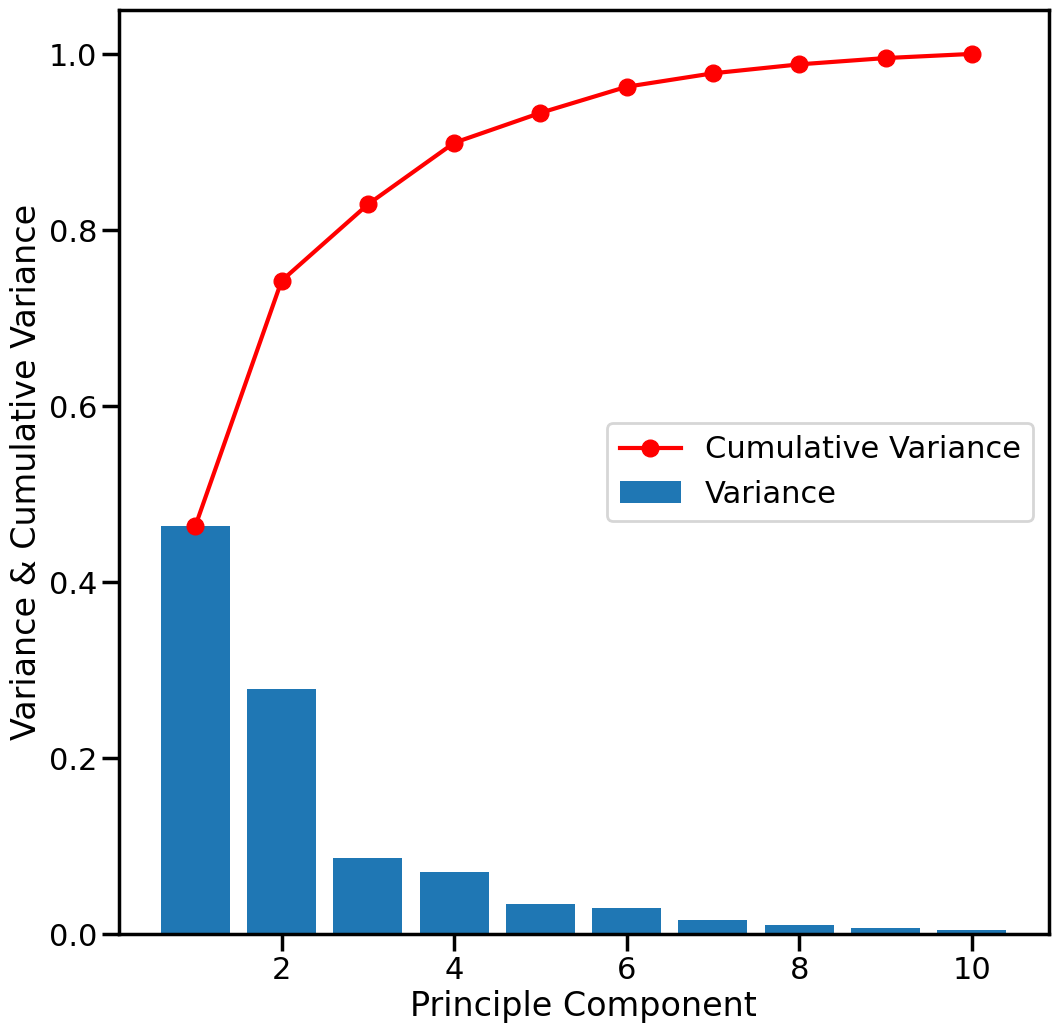

In [ ]:
sns.set_context('poster')
fig, ax1 = plt.subplots(figsize=(12,12))
ax1.bar(np.arange(n_components) + 1, pca.explained_variance_ratio_, color='#1f77b4')
ax1.set_xlabel('Principle Component')
ax1.set_ylabel('Variance & Cumulative Variance')
ax1.set_ybound(0, 1)
ax1.plot(np.arange(n_components) + 1, np.cumsum(pca.explained_variance_ratio_), 'r-o', zorder=2)
ax1.legend(['Cumulative Variance', 'Variance'])

plt.savefig(f"{supp_figures_path}/pca_explained_variance_ratio.pdf", bbox_inches='tight')

## Saving Coefficients

In [ ]:
params = copy.deepcopy(main_configs['socio_economic_parameter_names'])
params[-1] = 'log(Cat/Dog)'

i = np.identity(state_lev_data_std.shape[1])
coef = pca.transform(i)

coef_df = pd.DataFrame({'params': params,
                        'pc1': coef[:, 0].reshape(-1,),
                        'pc2': coef[:, 1].reshape(-1,)})

In [ ]:
coef_df

,params,pc1,pc2
0,Non-native Percentage,-0.190644,0.445308
1,Education (Percent Less Than High School),0.401486,-0.007066
2,Education (Percent Greater Than Bachelor),-0.405721,0.185800
3,Unemployment Percentage,0.085779,0.507289
4,Median Household Income,-0.410906,0.197403
5,Poverty,0.422411,0.133923
6,Black Percentage,0.206902,0.313862
7,2020 Presidential Election Index (Trump% - Bid...,0.307520,-0.344634
8,Social Capita,-0.310990,-0.407328
9,log(Cat/Dog),-0.221650,-0.263981


In [ ]:
coef_df.to_parquet(f"{dataframes_path}/socio_economic_params_pca_coefficients.parquet", index=False)